# Question 9

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

np.random.seed(42)
random.seed(42)

In [2]:
data = pd.read_csv('Project_1_dataset_01_01_2022.csv')

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
train1, test1 = train_test_split(data[["full_text","leaf_label"]], test_size = 0.2, random_state = 42)

In [5]:
train1.head(20)

,full_text,leaf_label
1431,More than 1 million Washingtonians participate...,flood
1567,A 4.7-magnitude earthquake rattled northwest S...,earthquake
1044,More campgrounds are coming to the Auburn Stat...,%22forest%20fire%22
175,Retro gamers will be able to relive all the jo...,cricket
1610,"SAN SIMEON, Calif. (KGTV) — An earthquake with...",earthquake
1885,San Francisco to Implement Water Surcharge in ...,drought
1343,Moderate flooding was possible in Charleston a...,flood
2061,© Rijasolo/AFP/Getty Images Madagascar has bee...,drought
123,© PA Images Geoff-Allardice\n\nAfter filling t...,cricket
432,The Miami Dolphins head coach said Tua Tagovai...,football


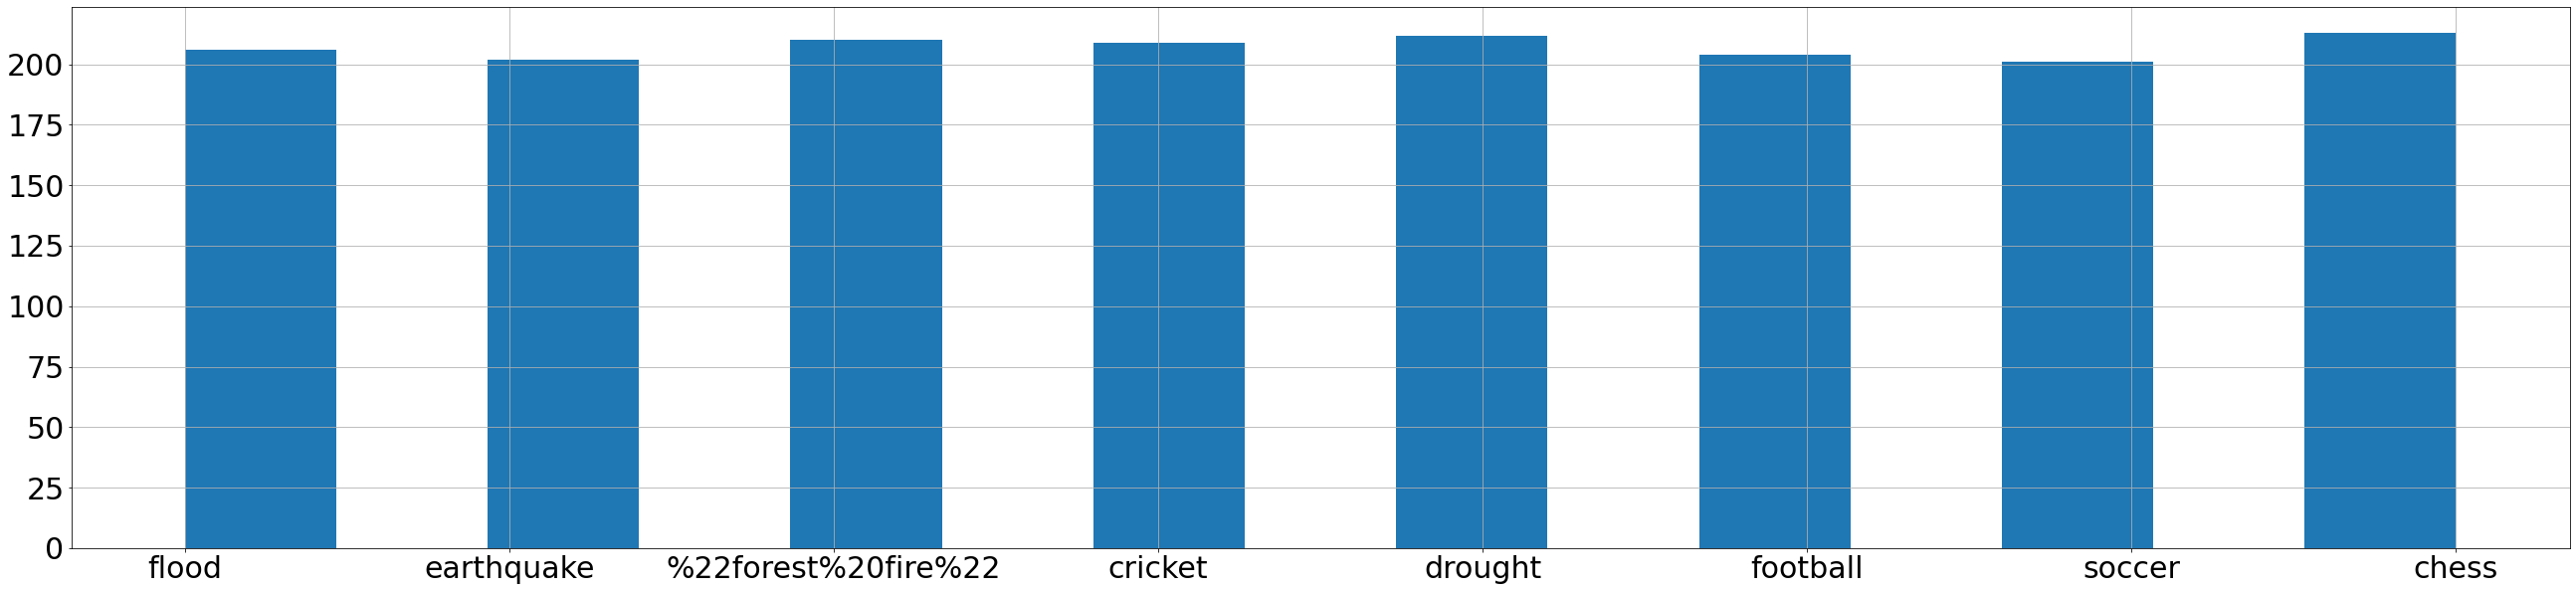

In [6]:
train1['leaf_label'].hist(bins=15, figsize=(45,10), xlabelsize = 30, ylabelsize = 30)
#plt.xlabel('leaf_label', size=50)
#plt.xlabel('Frequency', size=50)
plt.show()

In [7]:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

train1['full_text'] = train1['full_text'].map(lambda text: clean(text))
test1['full_text'] = test1['full_text'].map(lambda text: clean(text))

 

In [8]:
def label_num(x):
        map_row_to_class = {'chess':0, 'cricket': 1, 'soccer': 2, 'football': 3, '%22forest%20fire%22': 4, 'flood': 5, 'earthquake': 6, 'drought': 7}
        return map_row_to_class[x]

y_train1 = np.array(list(map(label_num, train1['leaf_label'])))
y_test1 = np.array(list(map(label_num, test1['leaf_label'])))

train1["target"] = y_train1
test1["target"] = y_test1

print(train1.shape)
print(test1.shape)

(1657, 3)
(415, 3)


In [9]:
import nltk
from string import punctuation

from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
analyzer = CountVectorizer().build_analyzer()

wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag): 
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if not word.isdigit())

vectorizer = CountVectorizer(stop_words = 'english',min_df = 3, analyzer = stem_rmv_punc)

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()



In [10]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

pipeline_Q9 = Pipeline([
    ('vect', vectorizer),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
])

categories_Q9 = ['chess', 'cricket','soccer', 'football','%22forest%20fire%22','flood','earthquake', 'drought']

X_train_Q9 = pipeline_Q9.fit_transform(train1['full_text'])
X_test_Q9 = pipeline_Q9.transform(test1['full_text'])
y_train_Q9 = train1['target']
y_test_Q9 = test1['target']

print(X_train_Q9.shape)
print(X_test_Q9.shape)

(1657, 50)
(415, 50)


Gaussian Multiclass Naive Bayes

In [11]:
from sklearn.metrics import auc, roc_curve, plot_roc_curve, plot_confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler()
X_train_Q9_scaled = min_max.fit_transform(X_train_Q9)
X_test_Q9_scaled = min_max.fit_transform(X_test_Q9)
mnb = MultinomialNB()
mnb.fit(X_train_Q9_scaled, y_train_Q9)
pred_mnb = mnb.predict(X_test_Q9_scaled)

print('accuracy:', accuracy_score(y_test_Q9, pred_mnb))
print('recall:', recall_score(y_test_Q9, pred_mnb, average='macro'))
print('precision:', precision_score(y_test_Q9, pred_mnb, average='macro'))
print('f1_score:', f1_score(y_test_Q9, pred_mnb, average='macro'))

accuracy: 0.8530120481927711
recall: 0.8579918844281739
precision: 0.8714967776154752
f1_score: 0.8549285215351176


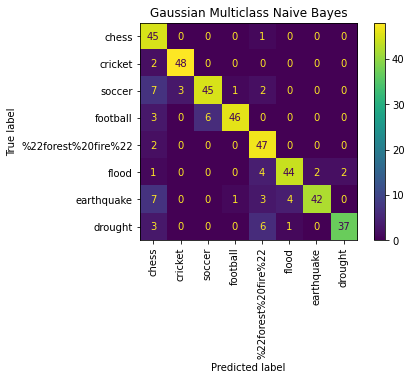

In [12]:
plot_confusion_matrix(mnb, X_test_Q9_scaled, y_test_Q9,display_labels=categories_Q9)
plt.xticks(rotation=90)
plt.title('Gaussian Multiclass Naive Bayes')
plt.show()

Multiclass SVM classification (One VS One)

In [13]:
from sklearn.svm import SVC
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

svm_1 = OneVsOneClassifier(svm.SVC(kernel='linear', random_state=42))
svm_1.fit(X_train_Q9, y_train_Q9)
pred_svm1 = svm_1.predict(X_test_Q9)

print('accuracy:', accuracy_score(y_test_Q9, pred_svm1))
print('recall:', recall_score(y_test_Q9, pred_svm1,average='macro'))
print('precision:', precision_score(y_test_Q9, pred_svm1,average='macro'))
print('f1_score:', f1_score(y_test_Q9, pred_svm1,average='macro'))

accuracy: 0.8795180722891566
recall: 0.8818524192649421
precision: 0.8986646382662803
f1_score: 0.8826587306851424


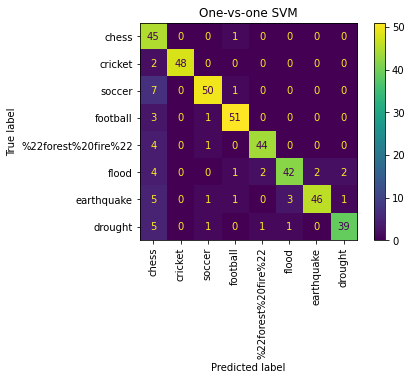

In [14]:
plot_confusion_matrix(svm_1, X_test_Q9, y_test_Q9, display_labels=categories_Q9)
plt.xticks(rotation=90)
plt.title('One-vs-one SVM')
plt.show()



Multiclass SVM classification (One VS Rest)

In [15]:
svm_2 = OneVsRestClassifier(svm.SVC(kernel='linear', random_state=42))
svm_2.fit(X_train_Q9, y_train_Q9)
pred_svm2 = svm_2.predict(X_test_Q9)

print('accuracy:', accuracy_score(y_test_Q9, pred_svm2))
print('recall:', recall_score(y_test_Q9, pred_svm2,average='macro'))
print('precision:', precision_score(y_test_Q9, pred_svm2,average='macro'))
print('f1_score:', f1_score(y_test_Q9, pred_svm2,average='macro'))

accuracy: 0.9132530120481928
recall: 0.9138606371325382
precision: 0.9125937533280915
f1_score: 0.9123144549712728


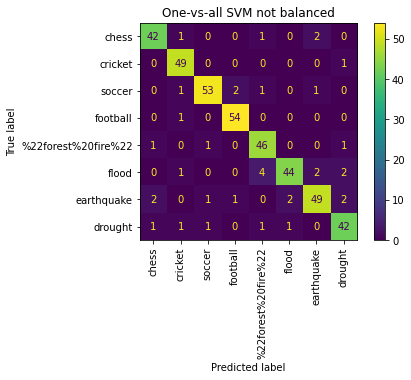

In [16]:
plot_confusion_matrix(svm_2, X_test_Q9, y_test_Q9,display_labels=categories_Q9)
plt.xticks(rotation=90)
plt.title('One-vs-all SVM not balanced')
plt.show()

In [17]:
svm_2 = OneVsRestClassifier(svm.SVC(kernel='linear', random_state=42, class_weight = 'balanced'))
svm_2.fit(X_train_Q9, y_train_Q9)
pred_svm2 = svm_2.predict(X_test_Q9)

print('accuracy:', accuracy_score(y_test_Q9, pred_svm2))
print('recall:', recall_score(y_test_Q9, pred_svm2,average='macro'))
print('precision:', precision_score(y_test_Q9, pred_svm2,average='macro'))
print('f1_score:', f1_score(y_test_Q9, pred_svm2,average='macro'))

accuracy: 0.9012048192771084
recall: 0.9027667506993806
precision: 0.9037678687583869
f1_score: 0.9006445985352068


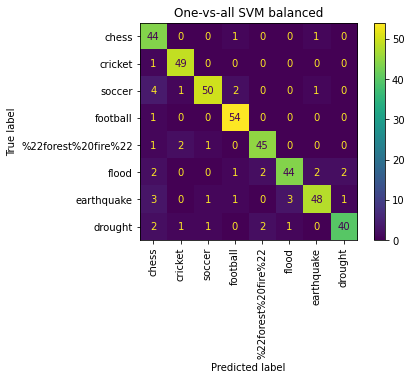

In [18]:
plot_confusion_matrix(svm_2, X_test_Q9, y_test_Q9,display_labels=categories_Q9)
plt.xticks(rotation=90)
plt.title('One-vs-all SVM balanced')
plt.show()

9(a) How did you resolve the class imbalance issue in the One VS the rest model.
 
I set the parameter class_weight = 'balanced', but for my database and for this case, the differences are not notable. (the acc even goes down after setting the parameter)
The four values and confusion matrix(1 Naive Bayes classification and  3 multiclass SVM classification (with both One VS One and
One VS the rest methods with and without class_weight = 'balanced ) are all shown above.
Since there are negative vałues in the feature matrix after LSI, which cannot be imported into the MultinomiaINB model, I use MinMaxScaler to scale the feature matrix after LSI. and make all the values in the feature matrix positive.

Gaussian Multiclass Naive Bayes:
accuracy: 0.8530120481927711
recall: 0.8579918844281739
precision: 0.8714967776154752
f1_score: 0.8549285215351176

Multiclass SVM classification (One VS One):
accuracy: 0.8795180722891566
recall: 0.8818524192649421
precision: 0.8986646382662803
f1_score: 0.8826587306851424

One-vs-all SVM not balanced:
accuracy: 0.9132530120481928
recall: 0.9138606371325382
precision: 0.9125937533280915
f1_score: 0.9123144549712728

One-vs-all SVM balanced

accuracy: 0.9012048192771084
recall: 0.9027667506993806
precision: 0.9037678687583869
f1_score: 0.9006445985352068

Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the
major diagonal? What does this mean?

There are all 8*8 matrix and the majority visible blocks are on the diagonal, which means that the models fit for the test set. In fact, the multi-class classification is satisfying for this database and all models.


In [19]:
# I am combining chess and soccer for One vs One SVM.
# I am combining %22forest%20fire%22 and flood for One vs all SVM.

categories_Q9_1 = ['chess', 'cricket','football','%22forest%20fire%22','flood','earthquake', 'drought']
categories_Q9_2 = ['chess', 'cricket','soccer', 'football','%22forest%20fire%22','earthquake', 'drought']

def label_num1(x):
        map_row_to_class = {'chess':0, 'cricket': 1, 'football': 2, '%22forest%20fire%22': 3, 'flood': 4, 'earthquake': 5, 'drought': 6}
        return map_row_to_class[x]
def label_num2(x):
        map_row_to_class = {'chess':0, 'cricket': 1, 'soccer': 2, 'football': 3, '%22forest%20fire%22': 4, 'earthquake': 5, 'drought': 6}
        return map_row_to_class[x]
    

train_merge1, test_merge1 = train_test_split(data[["full_text","leaf_label"]], test_size = 0.2, random_state = 42)
train_merge2, test_merge2 = train_test_split(data[["full_text","leaf_label"]], test_size = 0.2, random_state = 42)


train_merge1['leaf_label'].replace({'soccer': 'chess'}, inplace = True)
test_merge1['leaf_label'].replace({'soccer': 'chess'}, inplace = True)
train_merge2['leaf_label'].replace({'flood': '%22forest%20fire%22'}, inplace = True)
test_merge2['leaf_label'].replace({'flood': '%22forest%20fire%22'}, inplace = True)

y_train_merge1 = np.array(list(map(label_num1, train_merge1['leaf_label'])))
y_test_merge1 = np.array(list(map(label_num1, test_merge1['leaf_label'])))
y_train_merge2 = np.array(list(map(label_num2, train_merge2['leaf_label'])))
y_test_merge2 = np.array(list(map(label_num2, test_merge2['leaf_label'])))

train_merge1["target"] = y_train_merge1
test_merge1["target"] = y_test_merge1
train_merge2["target"] = y_train_merge2
test_merge2["target"] = y_test_merge2



In [20]:
X_train_merge1_Q9 = pipeline_Q9.fit_transform(train_merge1['full_text'])
X_test_merge1_Q9 = pipeline_Q9.transform(test_merge1['full_text'])
y_train_merge1_Q9 = train_merge1['target']
y_test_merge1_Q9 = test_merge1['target']

X_train_merge2_Q9 = pipeline_Q9.fit_transform(train_merge2['full_text'])
X_test_merge2_Q9 = pipeline_Q9.transform(test_merge2['full_text'])
y_train_merge2_Q9 = train_merge2['target']
y_test_merge2_Q9 = test_merge2['target']

accuracy: 0.8819277108433735
recall: 0.8676318255371159
precision: 0.9223411745387499
f1_score: 0.8891737569548869


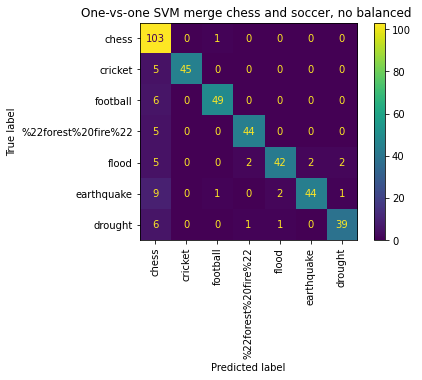

accuracy: 0.891566265060241
recall: 0.8819388343178091
precision: 0.9162897213035875
f1_score: 0.8962960197037078


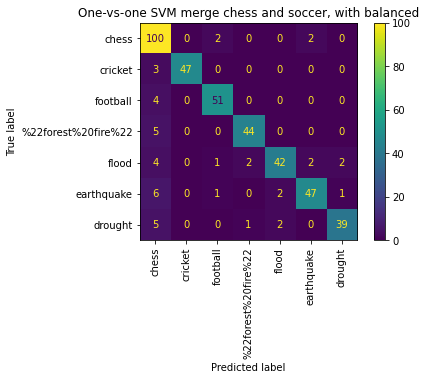

In [21]:
svm_1 = OneVsOneClassifier(svm.SVC(kernel='linear', random_state=42))
svm_1.fit(X_train_merge1_Q9, y_train_merge1_Q9)
pred_svm1 = svm_1.predict(X_test_merge1_Q9)

print('accuracy:', accuracy_score(y_test_merge1_Q9, pred_svm1))
print('recall:', recall_score(y_test_merge1_Q9, pred_svm1,average='macro'))
print('precision:', precision_score(y_test_merge1_Q9, pred_svm1,average='macro'))
print('f1_score:', f1_score(y_test_merge1_Q9, pred_svm1,average='macro'))

plot_confusion_matrix(svm_1, X_test_merge1_Q9, y_test_merge1_Q9, display_labels=categories_Q9_1)
plt.xticks(rotation=90)
plt.title('One-vs-one SVM merge chess and soccer, no balanced ')
plt.show()


svm_1 = OneVsOneClassifier(svm.SVC(kernel='linear', random_state=42, class_weight = 'balanced'))
svm_1.fit(X_train_merge1_Q9, y_train_merge1_Q9)
pred_svm1 = svm_1.predict(X_test_merge1_Q9)

print('accuracy:', accuracy_score(y_test_merge1_Q9, pred_svm1))
print('recall:', recall_score(y_test_merge1_Q9, pred_svm1,average='macro'))
print('precision:', precision_score(y_test_merge1_Q9, pred_svm1,average='macro'))
print('f1_score:', f1_score(y_test_merge1_Q9, pred_svm1,average='macro'))

plot_confusion_matrix(svm_1, X_test_merge1_Q9, y_test_merge1_Q9, display_labels=categories_Q9_1)
plt.xticks(rotation=90)
plt.title('One-vs-one SVM merge chess and soccer, with balanced')
plt.show()



accuracy: 0.9301204819277108
recall: 0.9303931243652925
precision: 0.9343200492850177
f1_score: 0.9319601530682887


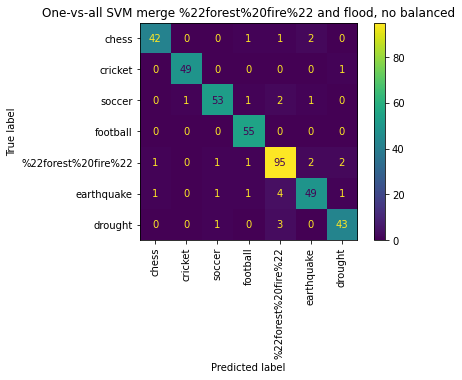

accuracy: 0.9060240963855422
recall: 0.9082189099122127
precision: 0.9044581267419218
f1_score: 0.9041660233730768


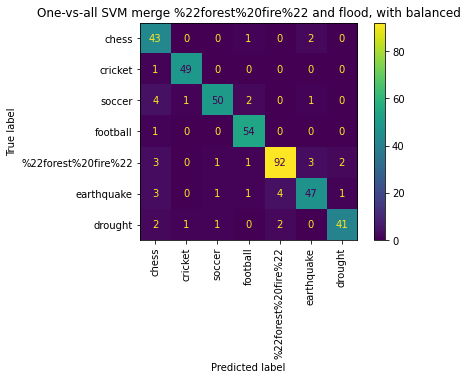

In [22]:
svm_2 = OneVsRestClassifier(svm.SVC(kernel='linear', random_state=42))
svm_2.fit(X_train_merge2_Q9, y_train_merge2_Q9)
pred_svm2 = svm_2.predict(X_test_merge2_Q9)

print('accuracy:', accuracy_score(y_test_merge2_Q9, pred_svm2))
print('recall:', recall_score(y_test_merge2_Q9, pred_svm2,average='macro'))
print('precision:', precision_score(y_test_merge2_Q9, pred_svm2,average='macro'))
print('f1_score:', f1_score(y_test_merge2_Q9, pred_svm2,average='macro'))

plot_confusion_matrix(svm_2, X_test_merge2_Q9, y_test_merge2_Q9,display_labels=categories_Q9_2)
plt.xticks(rotation=90)
plt.title('One-vs-all SVM merge %22forest%20fire%22 and flood, no balanced')
plt.show()

svm_2 = OneVsRestClassifier(svm.SVC(kernel='linear', random_state=42, class_weight = 'balanced'))
svm_2.fit(X_train_merge2_Q9, y_train_merge2_Q9)
pred_svm2 = svm_2.predict(X_test_merge2_Q9)

print('accuracy:', accuracy_score(y_test_merge2_Q9, pred_svm2))
print('recall:', recall_score(y_test_merge2_Q9, pred_svm2,average='macro'))
print('precision:', precision_score(y_test_merge2_Q9, pred_svm2,average='macro'))
print('f1_score:', f1_score(y_test_merge2_Q9, pred_svm2,average='macro'))

plot_confusion_matrix(svm_2, X_test_merge2_Q9, y_test_merge2_Q9,display_labels=categories_Q9_2)
plt.xticks(rotation=90)
plt.title('One-vs-all SVM merge %22forest%20fire%22 and flood, with balanced')
plt.show()

Merge

9(b) Based on your observation from the previous part, suggest a subset of labels that should be
merged into a new larger label and recompute the accuracy and plot the confusion matrix.
How did the accuracy change in One VS One and One VS the rest?

Based on my observation from the un-merge matrix for One vs One and One vs all, I merge 
chess and soccer for One vs One SVM and merge %22forest%20fire%22 and flood for One vs all SVM. The results and plots are shown above as well as below:

The most significant improvement is One VS All without balance before and after merging. The Acc changes from 0.913 to 0.930
The least significant improvement is One VS All with balance before and after merging. The Acc only changes from 0.901 to 0.906

9(c) Does class imbalance impact the performance of the classification once some classes are
merged? Provide a resolution for the class imbalance and recompute the accuracy and plot
the confusion matrix in One VS One and One VS the rest?.

Not at all. The effect of adding class_weight = 'balanced' paramter is not notable for mostly all the models. The reason is that we are merging two categories into one and the situation of imbalanced data has a little influence to the overall performance of each model.




RESULTS SUMMARY

One vs One:
Before merging, the results are: 

accuracy: 0.8795180722891566
recall: 0.8818524192649421
precision: 0.8986646382662803
f1_score: 0.8826587306851424 

After merging, the results for imbalanced and balanced are:

imbalanced:
accuracy: 0.8819277108433735
recall: 0.8676318255371159
precision: 0.9223411745387499
f1_score: 0.8891737569548869

balanced:
accuracy: 0.891566265060241
recall: 0.8819388343178091
precision: 0.9162897213035875
f1_score: 0.8962960197037078


One vs All:
Before merging, the results for imbalanced and balanced are:

imbalanced:
accuracy: 0.9132530120481928
recall: 0.9138606371325382
precision: 0.9125937533280915
f1_score: 0.9123144549712728

balanced:
accuracy: 0.9012048192771084
recall: 0.9027667506993806
precision: 0.9037678687583869
f1_score: 0.9006445985352068

After merging, the results for imbalanced and balanced are:

imbalanced:
accuracy: 0.9301204819277108
recall: 0.9303931243652925
precision: 0.9343200492850177
f1_score: 0.9319601530682887

balanced:
accuracy: 0.9060240963855422
recall: 0.9082189099122127
precision: 0.9044581267419218
f1_score: 0.9041660233730768
